<a href="https://colab.research.google.com/github/Uciolli/pneumonia-classifier/blob/main/pneumonia_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! git clone https://github.com/Uciolli/pneumonia-classifier


Cloning into 'pneumonia-classifier'...
remote: Enumerating objects: 5846, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 5846 (delta 3), reused 3 (delta 0), pack-reused 5836
Receiving objects: 100% (5846/5846), 1.13 GiB | 40.08 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (5859/5859), done.


# Classificador de Pneumonia

A nossa [base](https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy) é composta por raio-x do torax de crianças entre 1 a 5 anos. São 5863 imagens do torax de crianças sem pneumonia e crianças com pneumonia. O diagnostico de cada raio-x foi avaliado por 3 especialistas.

Para fazer o dataset, foram mantidas apenas os raio-x de maior qualidade. Classificadas em **Normal** e **Pneumonia**.

# Código

### Imports

In [68]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

- Função para ajustar as imagens, colocando-as no mesmo tamanho, na resolução de 150x150, e colocando todas em escala de cinza, facilitando para o leitor de imagem.

In [42]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(dir):
   data = [] 
   for label in labels: 
      path = os.path.join(dir, label)
      class_num = labels.index(label)
      for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
            data.append([resized_arr, class_num])
        except Exception as e:
            print(e)
   return np.array(data)

- Carregando as bases de treino, teste e validação

In [43]:
train = get_data('./pneumonia-classifier/chest_xray/train')
test  = get_data('./pneumonia-classifier/chest_xray/test') 
val   = get_data('./pneumonia-classifier/chest_xray/val') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


- Plotando um gráfico para mostrar o desbalanceamento da base de treino

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


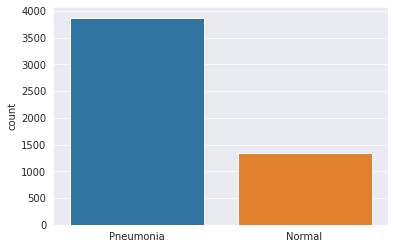

In [44]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

- Função que separa as bases em imagens (Características) e classes (Normal, Pneumonia)

In [45]:
def splitDataInImgAndLabel(data):
  x = []
  y = []
  for feature, label in data:
    x.append(feature)
    y.append(label)
  return x, y

- Separando as bases

In [46]:
x_train, y_train = splitDataInImgAndLabel(train)
x_val, y_val = splitDataInImgAndLabel(val)
x_test, y_test = splitDataInImgAndLabel(test)

- Normalizando as bases

In [47]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [48]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

- Gerando novas imagens para balancear a base de treino
 - Para isso foi aplicada um geração de imagens levemente modificadas, aplicando uma rotação de 30°, zoom de 20%, esticando na altura e largura em 10% e espelhando horizontalmente. Esses parametros não são usados para todas as imagens, é aleatórizado.

In [49]:
datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True)

datagen.fit(x_train)

- Criando o modelo
 - 22 camadas
 - Normalização de lotes

In [50]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

- Limitando a taxa de aprendizado

In [51]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

- Treinando o modelo

In [52]:
history = model.fit(
    datagen.flow(x_train,y_train, batch_size = 32),
    epochs = 12,
    validation_data = datagen.flow(x_val, y_val),
    callbacks = [learning_rate_reduction]
    )

Epoch 1/12
163/163 [==============================] - 13s 73ms/step - loss: 0.7220 - accuracy: 0.8355 - val_loss: 20.3851 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 11s 65ms/step - loss: 0.2794 - accuracy: 0.8972 - val_loss: 31.8903 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - 11s 66ms/step - loss: 0.2341 - accuracy: 0.9132 - val_loss: 2.1806 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 11s 65ms/step - loss: 0.2014 - accuracy: 0.9239 - val_loss: 0.5314 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/12
163/163 [==============================] - 11s 65ms/step - loss: 0.2004 - accuracy: 0.9296 - val_loss: 58.1434 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/12
163/163 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9413
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================]

- Perda e precisão do modelo

In [53]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 12ms/step - loss: 0.3460 - accuracy: 0.9183
Loss of the model is -  0.3460243046283722
20/20 [==============================] - 0s 12ms/step - loss: 0.3460 - accuracy: 0.9183
Accuracy of the model is -  91.82692170143127 %


In [69]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [70]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia', 'Normal']))

              precision    recall  f1-score   support

   Pneumonia       0.94      0.93      0.93       390
      Normal       0.89      0.90      0.89       234

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



- Gráfico da matriz de confusão do modelo

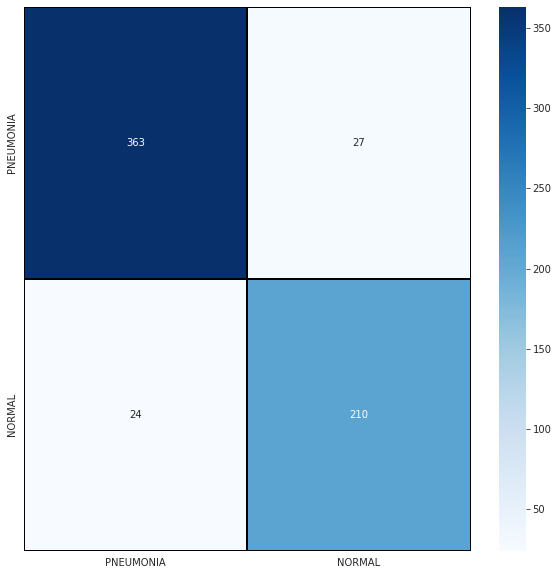

In [71]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

- Função para plotar 6 imagens

In [95]:
def plotImgs(data):
  i = 0
  for c in data[40:46]:
      plt.subplot(3,2,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
      plt.title("Previu {}, é {}".format(predictions[c] == 1 and 'normal' or 'pneumonia', y_test[c] == 1 and 'normal' or 'pneumonia'))
      plt.tight_layout()
      i += 1

- Comparando as predições com a base de teste e separando em dois vetores

In [98]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

- Acertos

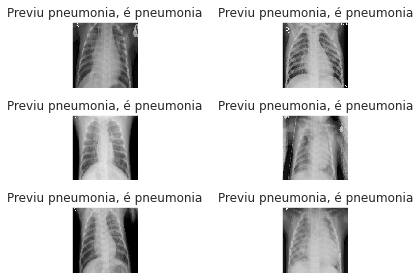

In [96]:
plotImgs(correct)

- Erros

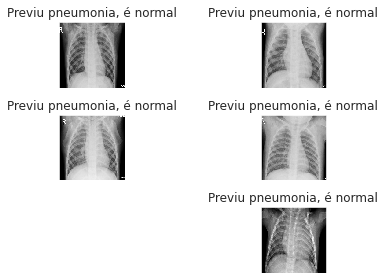

In [97]:
plotImgs(incorrect)